In [1]:
import numpy as np
import scipy as sp
import scipy.signal
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from matplotlib.animation import FuncAnimation

from cnld import abstract, simulation
from cnld.simulation import FixedStepSolver


array_file = 'single_membrane.json'
db_file = 'single_membrane.impresp.db'
t_start = 0
t_stop = 6e-6
atol = 1e-10

array = abstract.load(array_file)
patches = abstract.get_patches_from_array(array)


def surface_plot(patches):
    
    fig = plt.figure(figsize=(9,5))
    ax = plt.subplot(111, projection='3d')
    plt.tight_layout()
    
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    ax.set_zlim(-50, 50)
    
    ax.set_xlabel(r'x ($\mu m$)')
    ax.set_ylabel(r'y ($\mu m$)')
    ax.set_zlabel(r'z (nm)')

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    rects = []
    for j, p in enumerate(patches):
        x, y, z = p.position
        x = x / 1e-6
        y = y / 1e-6
        lx = p.length_x / 1e-6
        ly = p.length_y / 1e-6
        z = 0
        verts = [(x - lx / 2, y - ly / 2, z), 
                 (x - lx / 2, y + ly / 2, z), 
                 (x + lx / 2, y + ly / 2, z), 
                 (x + lx / 2, y - ly / 2, z)]
        rect = mplot3d.art3d.Poly3DCollection([verts], linewidths=1)
        rect.set_edgecolor('k')
        rects.append(rect)
        ax.add_collection3d(rect)
    
    return fig, ax, rects
    
    
def update(i, patches, rects, disp):

    for j, (p, r) in enumerate(zip(patches, rects)):
        x, y, z = p.position
        x = x / 1e-6
        y = y / 1e-6
        lx = p.length_x / 1e-6
        ly = p.length_y / 1e-6
        z = disp[i, j] / 1e-9
        verts = [(x - lx / 2, y - ly / 2, z), 
                 (x - lx / 2, y + ly / 2, z), 
                 (x + lx / 2, y + ly / 2, z), 
                 (x + lx / 2, y - ly / 2, z)]
        r.set_verts([verts])
        

In [2]:
''' Demonstration of fixed-point iteration '''
t1, v1 = simulation.logistic_ramp(1e-6, 5e-9, td=0.5e-6)
v1 = 20 * v1
t2, v2 = simulation.winsin(3e6, 5, 5e-9, td=1.5e-6)
v2 = 20 * v2
v_t, v = simulation.sigadd((t1, v1), (t2, v2))

solver = FixedStepSolver.from_array_and_db(array, db_file, v_t, v, t_start, t_stop, atol, maxiter=4)
solver.solve()

from scipy.signal import fftconvolve
pr = (solver.pressure).T[:,None,:]
xr = np.sum(fftconvolve(solver._fir, pr, axes=-1) * solver.min_step, axis=0).T
xr_t = np.arange(len(xr)) * solver.min_step

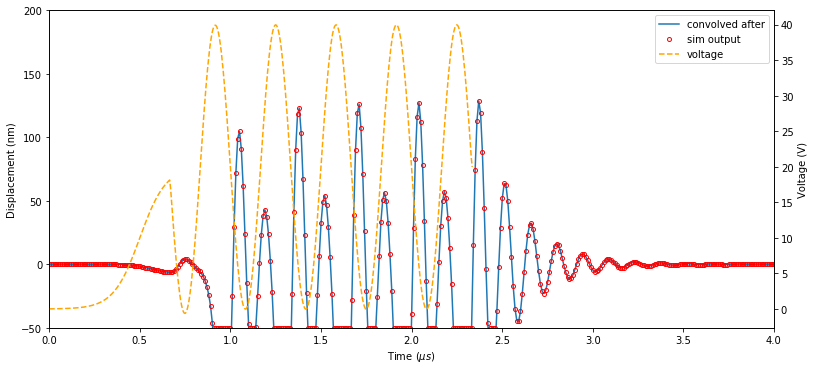

In [3]:
fig, ax = plt.subplots(figsize=(11,5))
tax = ax.twinx()
plt.tight_layout()

l1, = ax.plot(xr_t / 1e-6, xr[:, 4] / 1e-9)
l2, = ax.plot(solver.time / 1e-6, solver.displacement[:, 4] / 1e-9, 'o', fillstyle='none', 
              markersize=4, color='red')
l3, = tax.plot(v_t/ 1e-6, v, '--',color='orange')

ax.legend([l1, l2, l3], ['convolved after', 'sim output', 'voltage'])
ax.set_xlim(0, 4)
ax.set_ylim(-50, 200)

ax.set_xlabel(r'Time ($\mu s$)')
ax.set_ylabel('Displacement (nm)')
tax.set_ylabel('Voltage (V)');

In [4]:
''' DC collapse '''
t1, v1 = simulation.logistic_ramp(1e-6, 5e-9, tstop=t_stop, td=0.5e-6)
v1 = 30 * v1
t2, v2 = simulation.logistic_ramp(1e-6, 5e-9, tstop=t_stop, td=1.5e-6)
v2 = 2 * v2
t3, v3 = simulation.logistic_ramp(1e-6, 5e-9, tstop=t_stop, td=2.5e-6)
v3 = 10 * v3
v_t, v = simulation.sigadd((t1, v1), (t2, v2), (t3, v3))

solver = FixedStepSolver.from_array_and_db(array, db_file, v_t, v, t_start, t_stop, atol)
solver.solve()

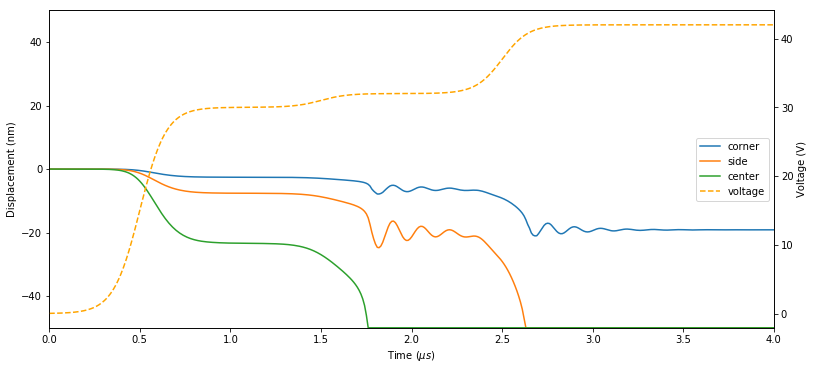

In [5]:
fig, ax = plt.subplots(figsize=(11,5))
tax = ax.twinx()
plt.tight_layout()

l1 = ax.plot(solver.time / 1e-6, solver.displacement[:, [0, 1, 4]] / 1e-9)
l2, = tax.plot(v_t / 1e-6, v, '--',color='orange')

ax.legend(l1 + [l2], ['corner', 'side', 'center', 'voltage'], loc='right')

ax.set_xlim(0, 4)
ax.set_ylim(-50, 50)

ax.set_xlabel(r'Time ($\mu s$)')
ax.set_ylabel('Displacement (nm)')
tax.set_ylabel('Voltage (V)');

In [6]:
# fig, ax, rects = surface_plot(patches)
# anim = FuncAnimation(fig, lambda i: update(i, patches, rects, solver.displacement), 
#                      frames=range(0, len(solver.time), 2), interval=5)
# anim.save('collapse.gif', dpi=80, writer='imagemagick', fps=20)

In [7]:
''' Frequency doubling '''
v_t, v = simulation.winsin(4e6, 10, 5e-9, td=1.5e-6)
v = 30 * v

solver = FixedStepSolver.from_array_and_db(array, db_file, v_t, v, t_start, t_stop, atol, maxiter=1)
solver.solve()

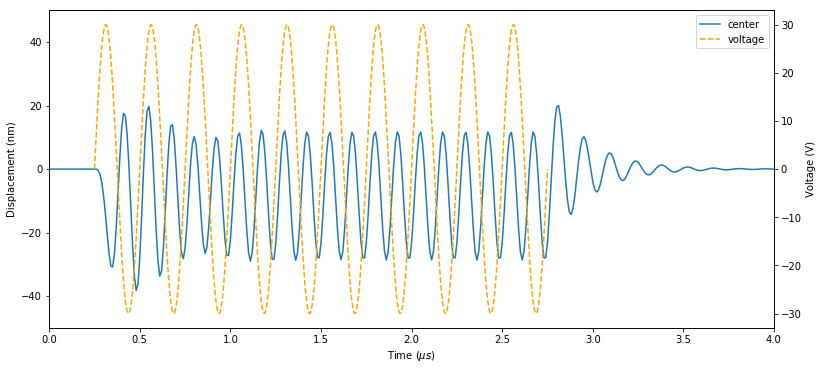

In [8]:
fig, ax = plt.subplots(figsize=(11,5))
tax = ax.twinx()
plt.tight_layout()

l1, = ax.plot(solver.time / 1e-6, solver.displacement[:, 4] / 1e-9)
l2, = tax.plot(v_t / 1e-6, v, '--',color='orange')

ax.legend([l1, l2], ['center', 'voltage'])

ax.set_xlim(0, 4)
ax.set_ylim(-50, 50)

ax.set_xlabel(r'Time ($\mu s$)')
ax.set_ylabel('Displacement (nm)')
tax.set_ylabel('Voltage (V)');

In [9]:
''' Collapse snap-back '''
t1, v1 = simulation.logistic_ramp(1e-6, 5e-9, tstop=t_stop, td=0.5e-6)
v1 = 20 * v1
t2, v2 = simulation.winsin(4e6, 7, 5e-9, td=2e-6)
v2 = 30 * v2
v_t, v = simulation.sigadd((t1, v1), (t2, v2))

solver = FixedStepSolver.from_array_and_db(array, db_file, v_t, v, t_start, t_stop, atol, maxiter=1)
solver.solve()

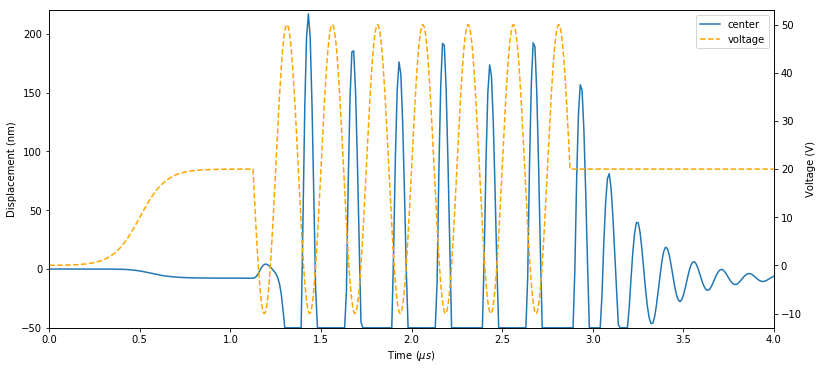

In [10]:
fig, ax = plt.subplots(figsize=(11, 5))
tax = ax.twinx()
plt.tight_layout()

l1, = ax.plot(solver.time / 1e-6, solver.displacement[:, 4] / 1e-9)
l2, = tax.plot(v_t / 1e-6, v, '--',color='orange')

ax.legend([l1, l2], ['center', 'voltage'])

ax.set_xlim(0, 4)
ax.set_ylim(-50, 220)

ax.set_xlabel(r'Time ($\mu s$)')
ax.set_ylabel('Displacement (nm)')
tax.set_ylabel('Voltage (V)');

In [11]:
# fig, ax, rects = surface_plot(patches)
# anim = FuncAnimation(fig, lambda i: update(i, patches, rects, solver.displacement), 
#                      frames=range(0, len(solver.time), 2), interval=5)
# anim.save('collapse-snapback.gif', dpi=80, writer='imagemagick', fps=20)

In [14]:
''' Linear ramp '''
v_t, v = simulation.linear_ramp(0.5e-6, 5e-9, tstop=t_stop)
v = 40 * v

solver = FixedStepSolver.from_array_and_db(array, db_file, v_t, v, t_start, t_stop, atol, maxiter=1)
solver.solve()

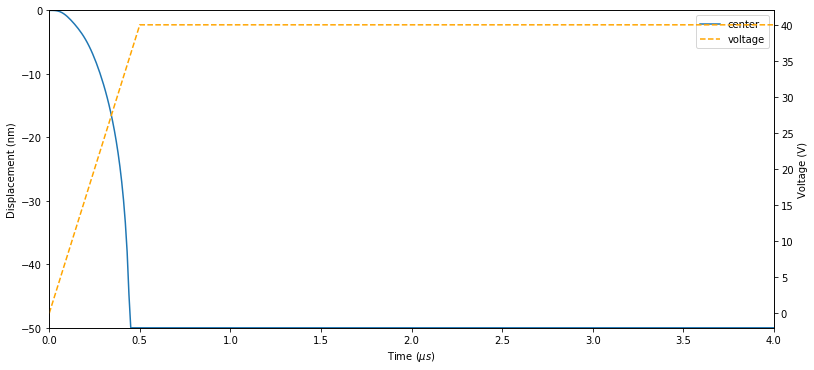

In [15]:
fig, ax = plt.subplots(figsize=(11, 5))
tax = ax.twinx()
plt.tight_layout()

l1, = ax.plot(solver.time / 1e-6, solver.displacement[:, 4] / 1e-9)
l2, = tax.plot(v_t / 1e-6, v, '--',color='orange')

ax.legend([l1, l2], ['center', 'voltage'])

ax.set_xlim(0, 4)
ax.set_ylim(-50, 0)

ax.set_xlabel(r'Time ($\mu s$)')
ax.set_ylabel('Displacement (nm)')
tax.set_ylabel('Voltage (V)');